1. Perform classification on FashionMNIST, fashion apparels dataset, using a pretrained model which is trained on MNIST handwritten digit classification dataset

In [43]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms,datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader

In [44]:
train_data = datasets.MNIST(root='./data',download=True,train=True,transform=ToTensor(),target_transform=None)
test_data = datasets.MNIST(root='./data',download=True,train=False,transform=ToTensor())

In [45]:
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [47]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [48]:
train_features_batch,train_labels_batch = next(iter(train_loader))
print(f"train_features_batch.shape:{train_features_batch.shape}\nlength of train_features batch:{len(train_features_batch)}")
print(f"train_labels_batch.shape:{train_labels_batch.shape}\nlength of train_labels batch:{len(train_labels_batch)}")

train_features_batch.shape:torch.Size([32, 1, 28, 28])
length of train_features batch:32
train_labels_batch.shape:torch.Size([32])
length of train_labels batch:32


(-0.5, 27.5, 27.5, -0.5)

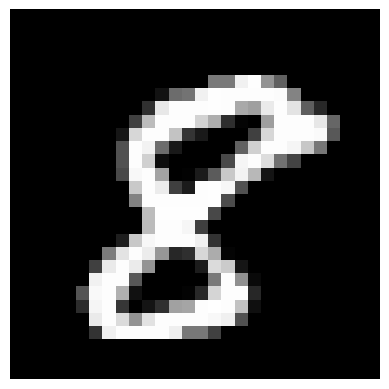

In [49]:
torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,labels = train_features_batch[rand_idx],train_labels_batch[rand_idx]
plt.imshow(img.reshape((28,28)),cmap='gray')
plt.axis('off')

In [50]:
class CNNclf(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=3),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True))

    def forward(self, x):
        x = self.net(x)
        #print(f"conv layer shape: {x.shape}")
        x = self.clf(x)
        #print(f"classifier shape: {x.shape}")
        return x

In [51]:
model = CNNclf().to(device)
#rand_img_tensor = torch.rand(1,28,28)
#rand_img_tensor.shape
model

CNNclf(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [52]:
#model(rand_img_tensor.unsqueeze(dim=0).to(device))

In [53]:
def accuracy_fn(y,y_pred):
    correct = torch.eq(y_pred,y).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)


In [55]:
def train_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    train_loss,train_acc = 0,0
    model.to(device)
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train accuracy: {train_acc:.5f}")


def test_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")


In [56]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch:{epoch}\n--------")
    train_step(model,train_loader,device,optimizer,loss_fn,accuracy_fn)
    test_step(model,test_loader,device,optimizer,loss_fn,accuracy_fn)


Epoch:0
--------
Train loss: 0.21370 Train accuracy: 93.30667
Test loss: 0.08473 | Test accuracy: 97.15455
Epoch:1
--------
Train loss: 0.06402 Train accuracy: 98.01667
Test loss: 0.07957 | Test accuracy: 97.39417
Epoch:2
--------
Train loss: 0.04396 Train accuracy: 98.58833
Test loss: 0.04499 | Test accuracy: 98.56230


In [57]:
train_dataset = datasets.FashionMNIST(root='./data',download=True,train=True,transform=ToTensor(),target_transform=None)
test_dataset = datasets.FashionMNIST(root='./data',download=True,train=False,transform=ToTensor())

In [58]:
train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32)

In [59]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}
torch.save(checkpoint, "model.pt")


In [60]:
checkpoint = torch.load('model.pt')
pretrained_model = CNNclf()
pretrained_model.load_state_dict(checkpoint['model_state_dict'])
pretrained_model.to(device)
pretrained_model

CNNclf(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [61]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
print(f"train_features_batch.shape: {train_features_batch.shape}")
print(f"train_labels_batch.shape: {train_labels_batch.shape}")

train_features_batch.shape: torch.Size([32, 1, 28, 28])
train_labels_batch.shape: torch.Size([32])


In [62]:
class_names = train_data.classes
len(class_names)

10

In [63]:
print("pretrained models state_dict:")
for param in pretrained_model.state_dict().keys():
    print(param,'/t',pretrained_model.state_dict()[param].size())
print()

pretrained models state_dict:
net.0.weight /t torch.Size([64, 1, 3, 3])
net.0.bias /t torch.Size([64])
net.3.weight /t torch.Size([128, 64, 3, 3])
net.3.bias /t torch.Size([128])
net.6.weight /t torch.Size([64, 128, 3, 3])
net.6.bias /t torch.Size([64])
clf.1.weight /t torch.Size([20, 64])
clf.1.bias /t torch.Size([20])
clf.3.weight /t torch.Size([10, 20])
clf.3.bias /t torch.Size([10])



In [64]:
torch.manual_seed(42)
pretrained_model.eval()
correct, total = 0, 0
for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = pretrained_model(X)
    y_pred_prob = torch.softmax(y_pred, dim=1)  # Applying softmax activation
    _, pred = torch.max(y_pred_prob, 1)  # Obtaining the class labels with highest probability
    print(f"True label: {y}\nPredicted label:{pred}")
    total += y.size(0)
    correct += (pred == y).sum().item()
accuracy = (correct / total) * 100
print(f"The overall accuracy: {accuracy}")


True label: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8], device='cuda:0')
Predicted label:tensor([2, 8, 8, 1, 0, 4, 4, 8, 2, 4, 0, 2, 2, 1, 0, 8, 0, 8, 0, 7, 0, 2, 2, 2,
        4, 0, 0, 7, 0, 8, 2, 2], device='cuda:0')
True label: tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5], device='cuda:0')
Predicted label:tensor([1, 8, 2, 8, 2, 2, 2, 1, 8, 4, 1, 2, 0, 2, 0, 8, 8, 0, 0, 8, 2, 0, 8, 0,
        0, 0, 0, 5, 2, 2, 8, 5], device='cuda:0')
True label: tensor([1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
        0, 6, 5, 3, 6, 7, 1, 8], device='cuda:0')
Predicted label:tensor([7, 8, 4, 8, 2, 2, 2, 5, 0, 7, 8, 1, 8, 0, 4, 0, 7, 8, 0, 8, 2, 8, 1, 8,
        7, 0, 2, 1, 0, 2, 1, 0], device='cuda:0')
True label: tensor([0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4], device='cud

2. Learn the AlexNet architecture and apply transfer learning to perform the classification
task. Using the pre-trained AlexNet, classify images from the cats_and_dogs_filtered
dataset downloaded from the below link. Finetune the classifier given in AlexNet as a twoclass classifier. Perform pre-processing of images as per the requirement.

In [65]:
#! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [66]:
#!unzip cats_and_dogs_filtered.zip

In [67]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop((32,32)),
    transforms.ToTensor()])

In [68]:
train_data = datasets.ImageFolder(root='/content/cats_and_dogs_filtered/train',transform=transforms)
test_data = datasets.ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=transforms)

In [69]:
train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=32)

In [70]:
from torchvision.models import alexnet,AlexNet_Weights
weights =  AlexNet_Weights.DEFAULT
weights

AlexNet_Weights.IMAGENET1K_V1

In [71]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [72]:
train_dataset = datasets.ImageFolder(root='/content/cats_and_dogs_filtered/train',transform=auto_transform)
test_dataset = datasets.ImageFolder(root='/content/cats_and_dogs_filtered/validation',transform=auto_transform)
train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32)
class_names = train_dataset.classes
print(f"No of Classes:{len(class_names)}")

No of Classes:2


In [73]:
model = alexnet(weights=weights).to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [74]:
!pip install torchinfo

In [75]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     23,296               True
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    307,392              True
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6)     

In [76]:
for param in model.features.parameters():
    param.requires_grad = False

In [77]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features,output_shape,bias=True)
).to(device)

In [78]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 55, 55]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 55, 55]     [32, 64, 55, 55]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 55, 55]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

In [79]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [80]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.eval()
    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [81]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch}:------")
    train_step(model,train_dataloader,loss_fn,optimizer,device)
    test_step(model,test_dataloader,loss_fn,device)


Epoch 0:------
Train Loss: 0.7714 | Train Accuracy: 0.8914
Test Loss: 0.1140 | Test Accuracy: 0.9570
Epoch 1:------
Train Loss: 0.2342 | Train Accuracy: 0.9444
Test Loss: 0.2186 | Test Accuracy: 0.9287
Epoch 2:------
Train Loss: 0.1601 | Train Accuracy: 0.9603
Test Loss: 0.3220 | Test Accuracy: 0.9463
Epoch 3:------
Train Loss: 0.1835 | Train Accuracy: 0.9638
Test Loss: 0.1602 | Test Accuracy: 0.9658
Epoch 4:------
Train Loss: 0.2806 | Train Accuracy: 0.9588
Test Loss: 0.2169 | Test Accuracy: 0.9521


In [87]:
from PIL import Image

def pred_and_plot_image(model, image_path, class_names, image_size, transform=None, device='cuda'):
    img = Image.open(image_path).convert("RGB")
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    model.to(device)
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

        predicted_class_index = torch.argmax(target_image_pred, dim=1).item()
        predicted_class = class_names[predicted_class_index]

        plt.imshow(img)
        plt.title(f"Predicted class: {predicted_class}")
        plt.axis('off')
        plt.show()


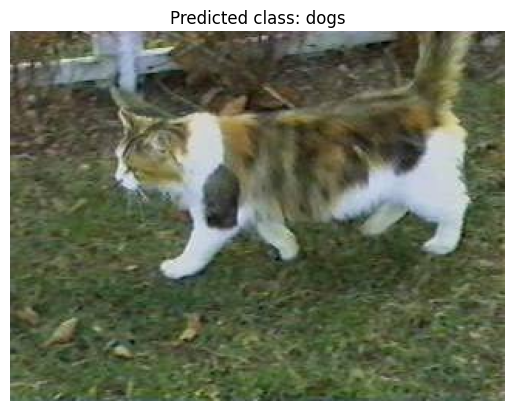

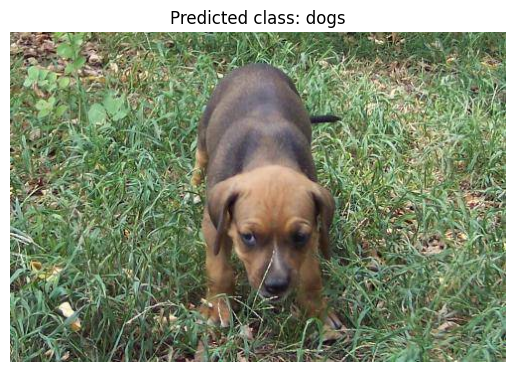

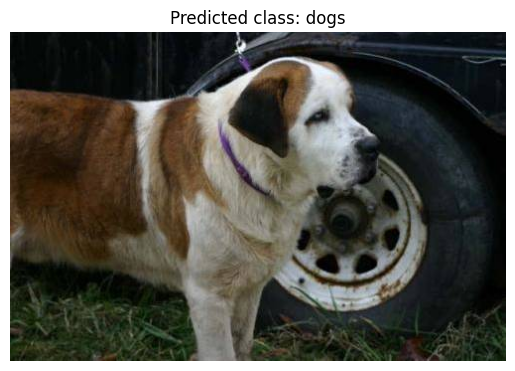

In [88]:
import random
from pathlib import Path
num = 3
test_path = Path('/content/cats_and_dogs_filtered/validation')
test_path_list = list(test_path.glob("*/*.jpg"))
test_image_sample =  random.sample(population=test_path_list,
                               k=num)
for image_path in test_image_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names = class_names,
                        transform=auto_transform,
                        image_size=(224,224))


3.Implement check points in PyTorch by saving model state_dict, optimizer state_dict, epochs
and loss during training so that the training can be resumed at a later point. Also, illustrate
the use of check point to save the best found parameters during training.

In [89]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import os

train_data = datasets.MNIST(root='./data', download=True, train=True, transform=ToTensor(), target_transform=None)
test_data = datasets.MNIST(root='./data', download=True, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"

class_names = train_data.classes

class CNNclf(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=3),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True))

    def forward(self, x):
        x = self.net(x)
        x = self.clf(x)
        return x

def accuracy_fn(y, y_pred):
    correct = torch.eq(y_pred, y).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

loss_fn = nn.CrossEntropyLoss()
model = CNNclf().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

def train_step(model, data_loader, device, optimizer, loss_fn, accuracy_fn):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train accuracy: {train_acc:.5f}")
    return train_loss

def test_step(model, data_loader, device, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")
    return test_loss

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

torch.manual_seed(42)
epochs = 3
best_test_loss = float('inf')
for epoch in range(epochs):
    print(f"Epoch:{epoch}\n--------")
    train_loss = train_step(model, train_loader, device, optimizer, loss_fn, accuracy_fn)
    test_loss = test_step(model, test_loader, device, loss_fn, accuracy_fn)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': test_loss,
            'train_loss': train_loss
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pt'))
        print('Checkpoint saved.')


Epoch:0
--------
Train loss: 0.23233 Train accuracy: 92.61167
Test loss: 0.07762 | Test accuracy: 97.64377
Checkpoint saved.
Epoch:1
--------
Train loss: 0.06550 Train accuracy: 97.97167
Test loss: 0.04793 | Test accuracy: 98.38259
Checkpoint saved.
Epoch:2
--------
Train loss: 0.04769 Train accuracy: 98.52667
Test loss: 0.04566 | Test accuracy: 98.50240
Checkpoint saved.
